# test des methodes d'interpretabilite : gradcam, occulusion, integrated gradient

In [209]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim

In [210]:
import joblib
import seaborn as sns

## chargement du modèle et des predictions

In [211]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()

In [212]:
model = joblib.load('../models/C2.pkl')

In [213]:
X_valid, y_valid = load_balanced.load('../data/raw/mitbih_test.csv')
X_valid =np.expand_dims(X_valid,axis=1)

valid_set =  TensorDataset(torch.from_numpy(X_valid).float(), torch.Tensor(torch.from_numpy(y_valid).long()))

In [214]:
X,y = valid_set[:]

              precision    recall  f1-score   support

           0      0.993     0.993     0.993     18118
           1      0.852     0.831     0.842       556
           2      0.973     0.957     0.965      1448
           3      0.783     0.846     0.813       162
           4      0.989     0.994     0.992      1608

    accuracy                          0.986     21892
   macro avg      0.918     0.924     0.921     21892
weighted avg      0.986     0.986     0.986     21892



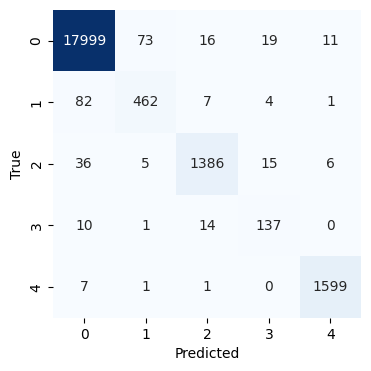

In [215]:
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

### identification des bonnes et mauvaises predictions

In [216]:
class_error = {}
class_correct = {}

for classif in range(5):
    class_error[classif] = [k for k,x in enumerate(y_true) if (x==classif and y_pred[k] !=classif)]
    class_correct[classif] = [k for k,x in enumerate(y_true) if (x==classif and y_pred[k] ==classif)]
    print('class ', classif, ' --  erreurs : ',len(class_error[classif]), '  -- OK:', len(class_correct[classif]))


class  0  --  erreurs :  119   -- OK: 17999
class  1  --  erreurs :  94   -- OK: 462
class  2  --  erreurs :  62   -- OK: 1386
class  3  --  erreurs :  25   -- OK: 137
class  4  --  erreurs :  9   -- OK: 1599


In [13]:
X,y = valid_set[:]

### exeample de signal

In [217]:
ii=5670

In [218]:
signal = X[ii]

Text(0.5, 1.0, 'true: 0, predicted 0')

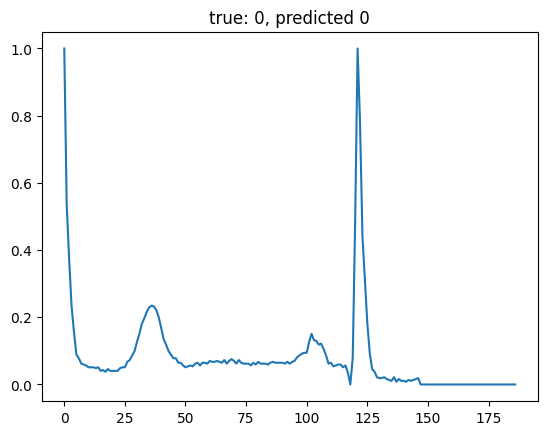

In [219]:
plt.plot(signal[0,:])
plt.title('true: %d,' %(y_valid[ii])+' predicted %d' %(y_pred[ii]) )

## grad cam

In [220]:

def make_gradcam_heatmap(signal_tensor, model, target_layer_name, pred_index=None):   
    # Passer en avant pour obtenir les prédictions et les activations de la couche cible
    def forward_hook(module, input, output):
        model.features = output

    # Enregistrer un hook sur la couche cible pour récupérer ses sorties
    hook = model._modules.get(target_layer_name).register_forward_hook(forward_hook)
    
    # Effectuer une passe avant pour obtenir les sorties du modèle
    output = model(signal_tensor)
    
    # Supprimer le hook après avoir récupéré les activations
    hook.remove()

    # Si aucun indice de prédiction n'est fourni, utiliser celui avec la plus haute probabilité
    if pred_index is None:
        pred_index = output.argmax(dim=1).item()
    
    # Valeur de probabilité de la classe
    y = output[0, pred_index]
    
    # Passer en arrière pour obtenir les gradients de la couche cible
    model.zero_grad()  # Remettre à zéro les gradients
    model.features.retain_grad()  # Garder les gradients de la couche cible
    y.backward(retain_graph=True)  # Calculer les gradients par rétropropagation

    # Obtenir les gradients et les activations de la couche cible
    gradients = model.features.grad[0]
    activations = model.features[0]

    # Appliquer un pooling global moyen sur les gradients
    pooled_grads = torch.mean(gradients, dim=[1])

    # Pondérer les activations par les gradients
    for i in range(len(pooled_grads)):
        activations[i, :] *= pooled_grads[i]

    # Calculer la heatmap
    heatmap = torch.mean(activations, dim=0).detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # Ne conserver que les valeurs positives
    heatmap /= np.max(heatmap)  # Normaliser la heatmap

    return heatmap

In [221]:
heatmap = make_gradcam_heatmap(X[ii].unsqueeze(0), model, '11', pred_index=int(y[ii]))

Text(0.5, 1.0, 'Grad-CAM')

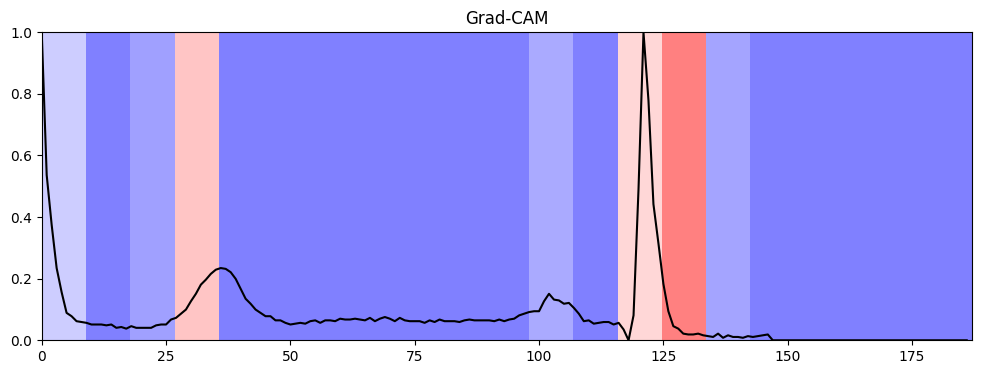

In [222]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(X[ii,0,:],color='k')
ax.set_title('Grad-CAM')

## Integrated Gradients

In [223]:
device = "cpu"

def show_importance(input_tensor,model,target_layer_name, pred_index=0, device=device):

    lig = LayerIntegratedGradients(model, model._modules.get(target_layer_name))
    input_tensor = input_tensor.to(device)
    model.to(device)
    # Compute the importance score for each input values.
    attributions, delta = lig.attribute(inputs=input_tensor, target=pred_index,
                                    return_convergence_delta=True, n_steps=100)
    
    # Transform the importance score to importance of each token.
    importance = attributions.sum(dim=1).squeeze(0)
    importance = importance / torch.norm(importance)
    importance = importance.cpu().detach().numpy()
    # Une autre normalisation est possible (similaire à celle du grad-cam)
    # importance = np.maximum(importance, 0)  # Ne garder que les valeurs positives
    # importance /= np.max(importance)  # Normaliser la heatmap
    return importance

In [224]:
heatmap = show_importance(X[ii].unsqueeze(0), model, '11', pred_index=int(y[ii]))

Text(0.5, 1.0, 'Integrated Gradients')

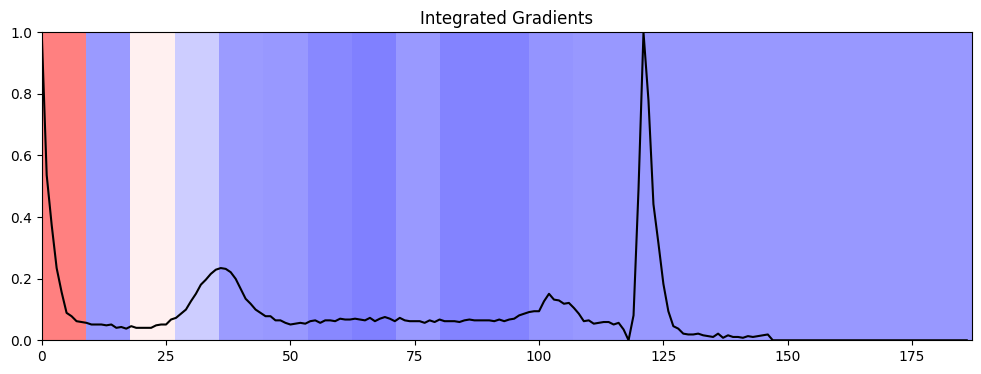

In [225]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(importance,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(signal[0,:],color='k')
ax.set_title('Integrated Gradients')

In [226]:
from captum.attr import LayerGradCam

def show_importance_gradcam(input_tensor, model,  target_layer_name,target=0, device="cpu"):

    lig = LayerGradCam(model, model._modules.get(target_layer_name))

    input_tensor = input_tensor.to(device)
    model.to(device)
    # Calculer le score d'importance de la même taille que model._modules.get('layer4')
    attributions = lig.attribute(inputs=input_tensor, target=target)
    
    # Score d'importance pour chaque pixel de l'image
    importance = attributions.sum(dim=1).squeeze(0)

    # Même normalisation que l'approche du Grad-CAM.
    importance = importance.cpu().detach().numpy()
    importance = np.maximum(importance, 0)  # Ne garder que les valeurs positives
    importance /= np.max(importance)  # Normaliser la heatmap
    
    
    
    return importance


In [227]:
heatmap = show_importance_gradcam(X[ii].unsqueeze(0), model, '11', target=int(y[ii]))

Text(0.5, 1.0, 'Captum Gradcam')

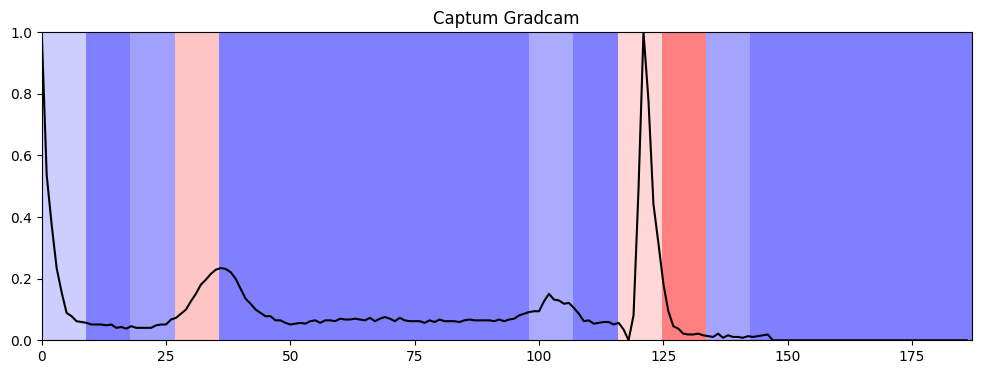

In [229]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(signal[0,:],color='k')
ax.set_title('Captum Gradcam')

### Occlusion

In [230]:
from captum.attr import Occlusion

sliding_window_shapes=( 1, 10)  # choose size enough to change object appearance


def show_importance_occlusion(input_tensor,model, target=0, device="cpu"):
    lig = Occlusion(model)

    input_tensor = input_tensor.to(device)
    model.to(device)
    # Compute the importance score for each input values.
    attributions = lig.attribute(inputs=input_tensor, strides = (1,1), target=target, sliding_window_shapes=sliding_window_shapes)
    
    # Transform the importance score to importance of each token.
    importance = attributions.sum(dim=1).squeeze(0)
#     importance = importance / torch.norm(importance)
    importance = importance.cpu().detach().numpy()
    importance = np.maximum(importance, 0)  # Ne garder que les valeurs positives
    importance /= np.max(importance)  # Normaliser la heatmap
    
    return importance


In [231]:
heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))

Text(0.5, 1.0, 'Occlusion')

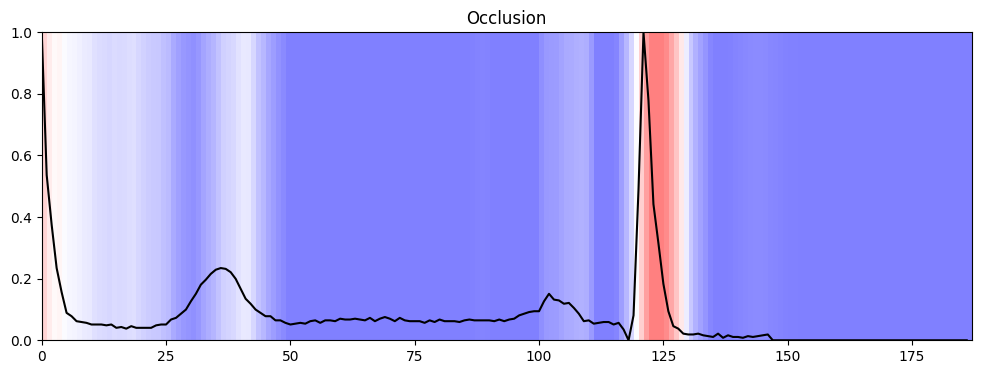

In [232]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(signal[0,:],color='k')
ax.set_title('Occlusion')

In [164]:
kk = 1
ii = class_correct[kk][0]
print(ii,'true:',kk,'prediction',y_pred[ii])


18118 true: 1 prediction 1


Text(0.5, 1.0, 'Occlusion- classe 0 - prediction 0')

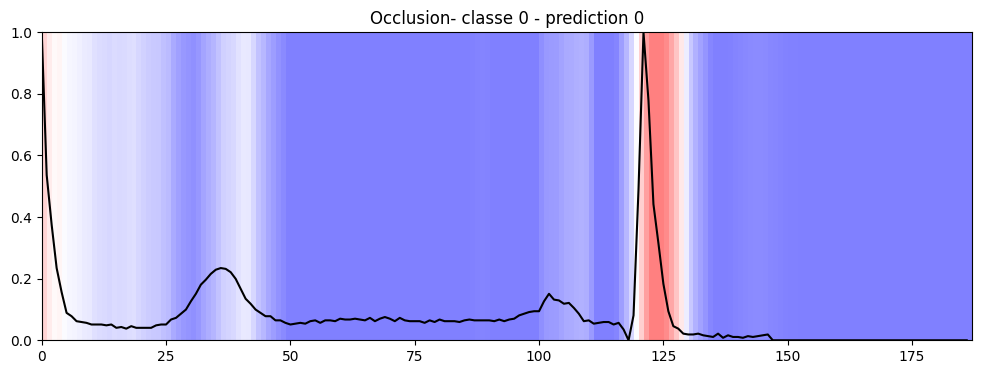

In [233]:
heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(X[ii,0,:],color='k')
ax.set_title('Occlusion- classe %d' %kk +' - prediction %d' %(y_pred[ii]))

In [166]:
ii = class_error[kk][0]
print(ii)
print(ii,'true:',kk,'prediction',y_pred[ii])


18119
18119 true: 1 prediction 0


Text(0.5, 1.0, 'Occlusion- classe 1 - prediction 0')

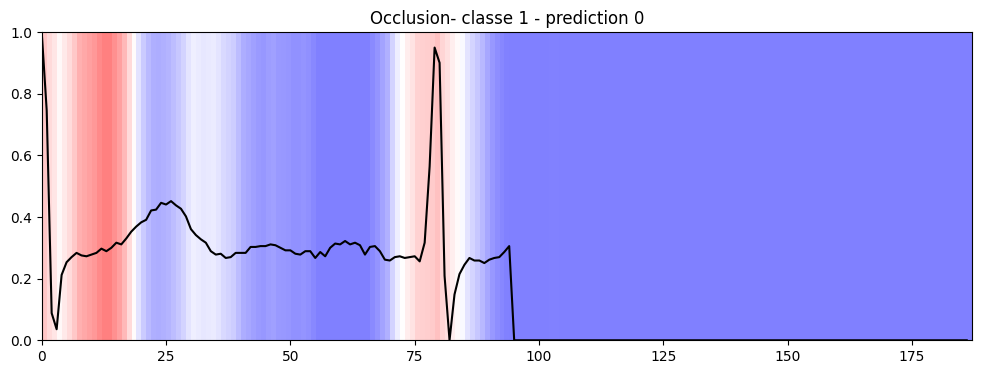

In [167]:
heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(X[ii,0,:],color='k')
ax.set_title('Occlusion- classe 1 - prediction %d' %(y_pred[ii]))

329
329 true: 0 prediction 3


Text(0.5, 1.0, 'Occlusion- classe 0 - prediction 3')

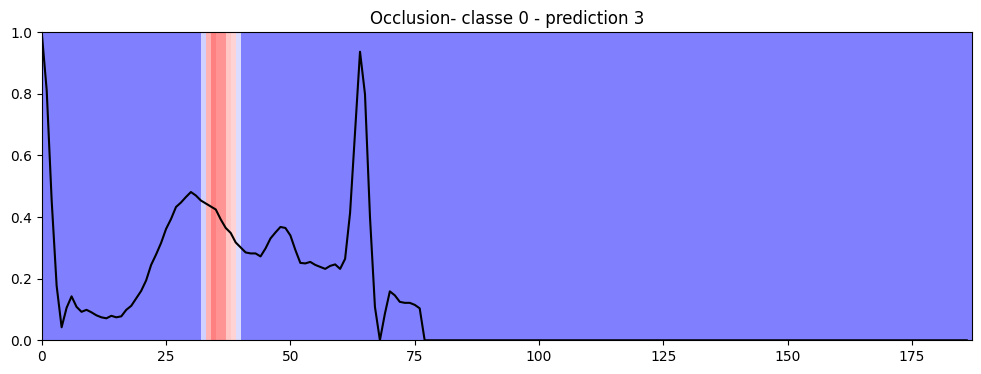

In [170]:
kk=0
ii = class_error[0][0]
print(ii)
print(ii,'true:',kk,'prediction',y_pred[ii])
heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(X[ii,0,:],color='k')
ax.set_title('Occlusion- classe %d ' %kk +'- prediction %d' %(y_pred[ii]))

0
0 true: 0 prediction 0


Text(0.5, 1.0, 'Occlusion- classe 0 - prediction 0')

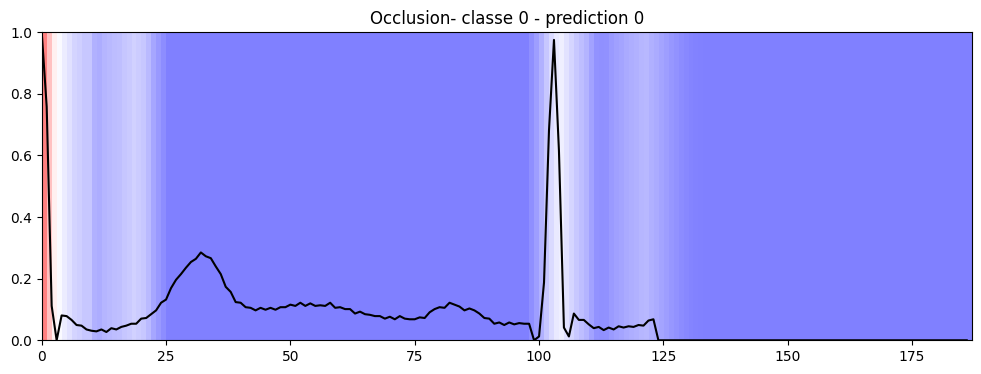

In [171]:
kk=0
ii = class_correct[0][0]
print(ii)
print(ii,'true:',kk,'prediction',y_pred[ii])
heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot()
im = ax.imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
ax.plot(X[ii,0,:],color='k')
ax.set_title('Occlusion- classe %d ' %kk +'- prediction %d' %(y_pred[ii]))

18250
18250 true: 1 prediction 0
18199
18199 true: 1 prediction 0
18270
18270 true: 1 prediction 2
18622
18622 true: 1 prediction 4
18554
18554 true: 1 prediction 0
18652
18652 true: 1 prediction 0
18359
18359 true: 1 prediction 0
18604
18604 true: 1 prediction 0
18396
18396 true: 1 prediction 0
18466
18466 true: 1 prediction 0
18215
18215 true: 1 prediction 0
18151
18151 true: 1 prediction 0
18525
18525 true: 1 prediction 0
18397
18397 true: 1 prediction 0
18407
18407 true: 1 prediction 0
18423
18423 true: 1 prediction 0
18558
18558 true: 1 prediction 2
18124
18124 true: 1 prediction 0
18386
18386 true: 1 prediction 0
18545
18545 true: 1 prediction 0


Text(0.5, 1.0, 'Occlusion- classe 1 - prediction correcte')

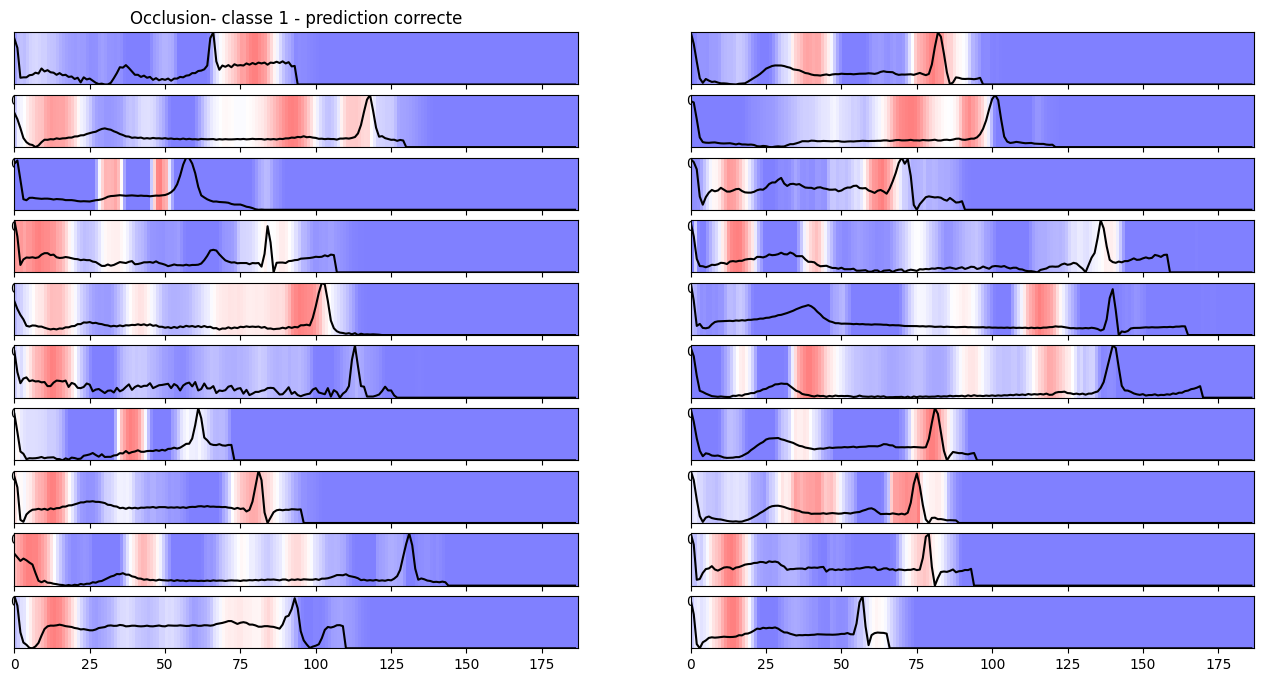

In [196]:
kk=1
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction correcte')

18554
18554 true: 1 prediction 0
18622
18622 true: 1 prediction 4
18519
18519 true: 1 prediction 0
18489
18489 true: 1 prediction 0
18423
18423 true: 1 prediction 0
18140
18140 true: 1 prediction 3
18165
18165 true: 1 prediction 0
18570
18570 true: 1 prediction 3
18119
18119 true: 1 prediction 0
18407
18407 true: 1 prediction 0
18648
18648 true: 1 prediction 0
18396
18396 true: 1 prediction 0
18199
18199 true: 1 prediction 0
18376
18376 true: 1 prediction 0
18417
18417 true: 1 prediction 0
18424
18424 true: 1 prediction 0
18448
18448 true: 1 prediction 2
18359
18359 true: 1 prediction 0
18459
18459 true: 1 prediction 0
18620
18620 true: 1 prediction 3


Text(0.5, 1.0, 'Occlusion- classe 1 - prediction error')

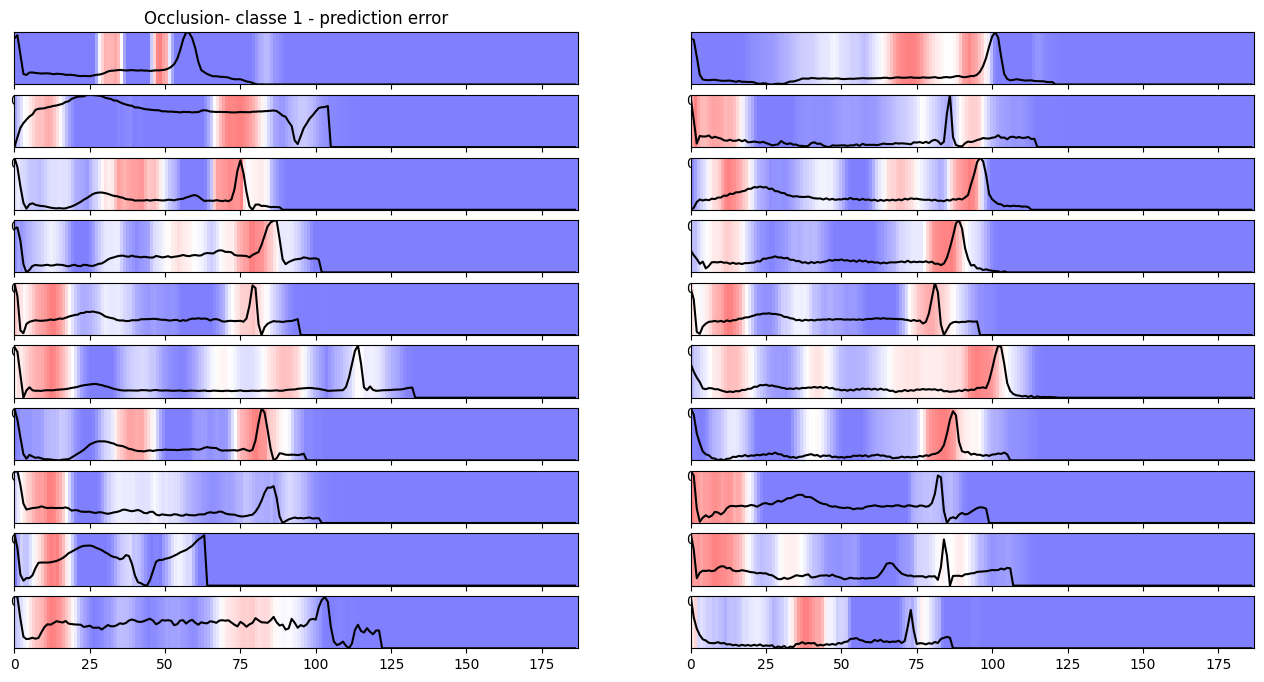

In [197]:
kk=1
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction error')

### Classe 3

20279
20279 true: 3 prediction 2
20249
20249 true: 3 prediction 2
20150
20150 true: 3 prediction 2
20246
20246 true: 3 prediction 2
20261
20261 true: 3 prediction 2
20235
20235 true: 3 prediction 2
20277
20277 true: 3 prediction 0
20142
20142 true: 3 prediction 0
20124
20124 true: 3 prediction 0
20183
20183 true: 3 prediction 2
20123
20123 true: 3 prediction 0
20207
20207 true: 3 prediction 2
20162
20162 true: 3 prediction 0
20211
20211 true: 3 prediction 2
20219
20219 true: 3 prediction 0
20126
20126 true: 3 prediction 2
20186
20186 true: 3 prediction 1
20231
20231 true: 3 prediction 2
20196
20196 true: 3 prediction 0
20255
20255 true: 3 prediction 0


Text(0.5, 1.0, 'Occlusion- classe 3 - prediction ok')

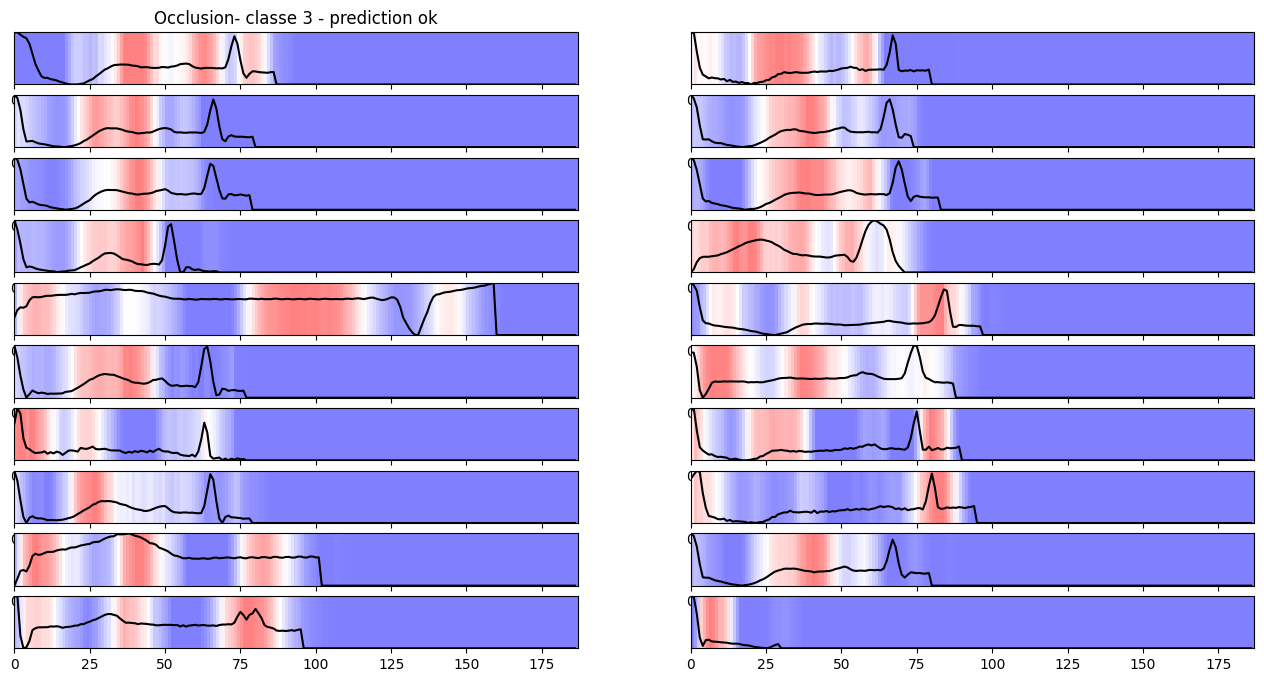

In [198]:
kk=3
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction ok')

25
20246
20246 true: 3 prediction 2
20124
20124 true: 3 prediction 0
20221
20221 true: 3 prediction 2
20196
20196 true: 3 prediction 0
20150
20150 true: 3 prediction 2
20255
20255 true: 3 prediction 0
20249
20249 true: 3 prediction 2
20207
20207 true: 3 prediction 2
20235
20235 true: 3 prediction 2
20231
20231 true: 3 prediction 2
20164
20164 true: 3 prediction 0
20142
20142 true: 3 prediction 0
20197
20197 true: 3 prediction 2
20186
20186 true: 3 prediction 1
20279
20279 true: 3 prediction 2
20160
20160 true: 3 prediction 0
20211
20211 true: 3 prediction 2
20219
20219 true: 3 prediction 0
20261
20261 true: 3 prediction 2
20183
20183 true: 3 prediction 2


Text(0.5, 1.0, 'Occlusion- classe 3 - prediction error')

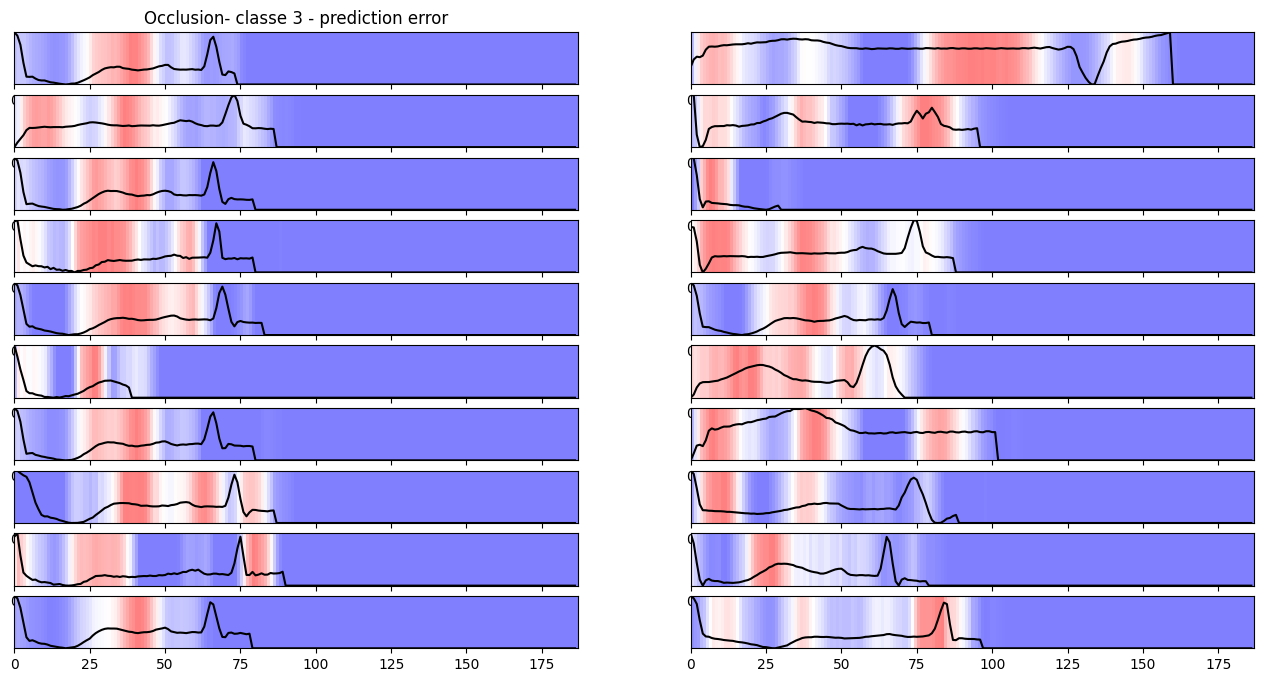

In [201]:
kk=3
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()

b = class_error[kk]
print(len(b))
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction error')

### classe 2

18840
18840 true: 2 prediction 2
18713
18713 true: 2 prediction 2
19685
19685 true: 2 prediction 2
19005
19005 true: 2 prediction 2
19375
19375 true: 2 prediction 2
19723
19723 true: 2 prediction 2
19375
19375 true: 2 prediction 2
19877
19877 true: 2 prediction 2
19285
19285 true: 2 prediction 2
19501
19501 true: 2 prediction 2
19027
19027 true: 2 prediction 2
19216
19216 true: 2 prediction 2
18773
18773 true: 2 prediction 2
19132
19132 true: 2 prediction 2
18837
18837 true: 2 prediction 2
20090
20090 true: 2 prediction 2
18919
18919 true: 2 prediction 2
19976
19976 true: 2 prediction 2
18756
18756 true: 2 prediction 2
19304
19304 true: 2 prediction 2


Text(0.5, 1.0, 'Occlusion- classe 2 - prediction ok')

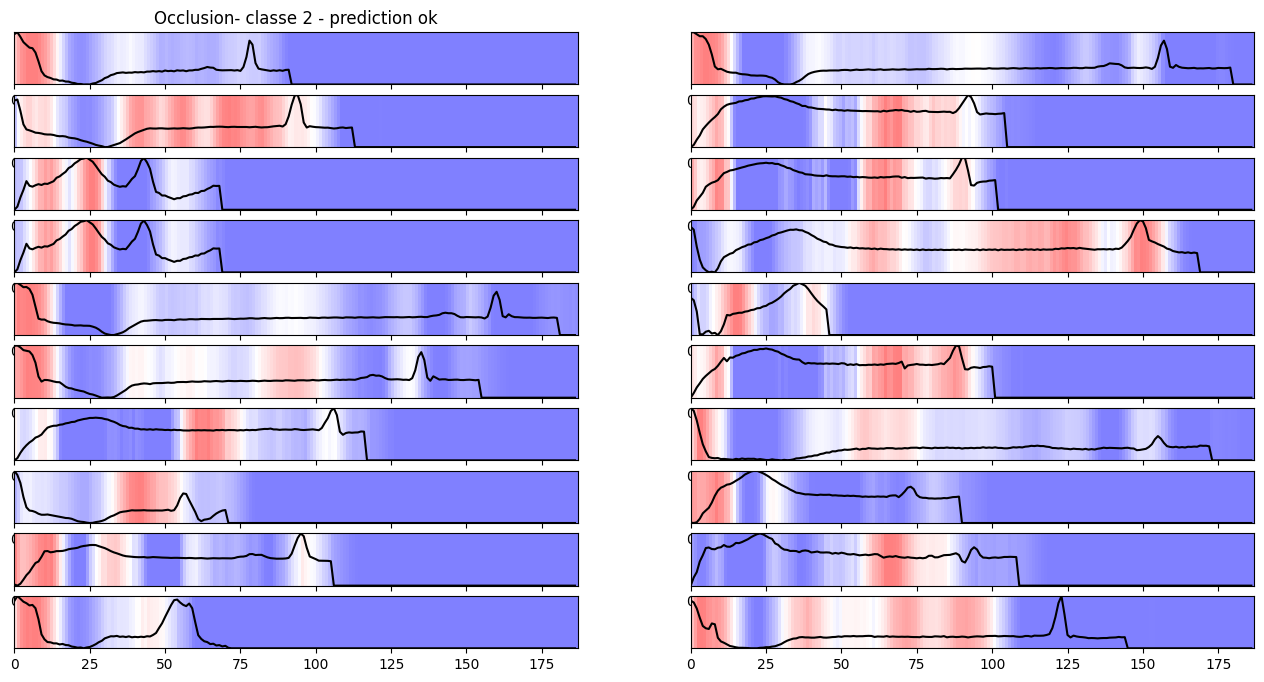

In [183]:
kk=2
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction ok')

18844
18844 true: 2 prediction 3
18733
18733 true: 2 prediction 0
19235
19235 true: 2 prediction 3
20120
20120 true: 2 prediction 0
19272
19272 true: 2 prediction 4
19824
19824 true: 2 prediction 1
20104
20104 true: 2 prediction 0
19692
19692 true: 2 prediction 4
18980
18980 true: 2 prediction 4
19539
19539 true: 2 prediction 0
19462
19462 true: 2 prediction 0
19996
19996 true: 2 prediction 3
18796
18796 true: 2 prediction 0
18967
18967 true: 2 prediction 0
19880
19880 true: 2 prediction 0
18876
18876 true: 2 prediction 0
18728
18728 true: 2 prediction 0
18705
18705 true: 2 prediction 0
19292
19292 true: 2 prediction 0
19822
19822 true: 2 prediction 0


Text(0.5, 1.0, 'Occlusion- classe 2 - prediction error')

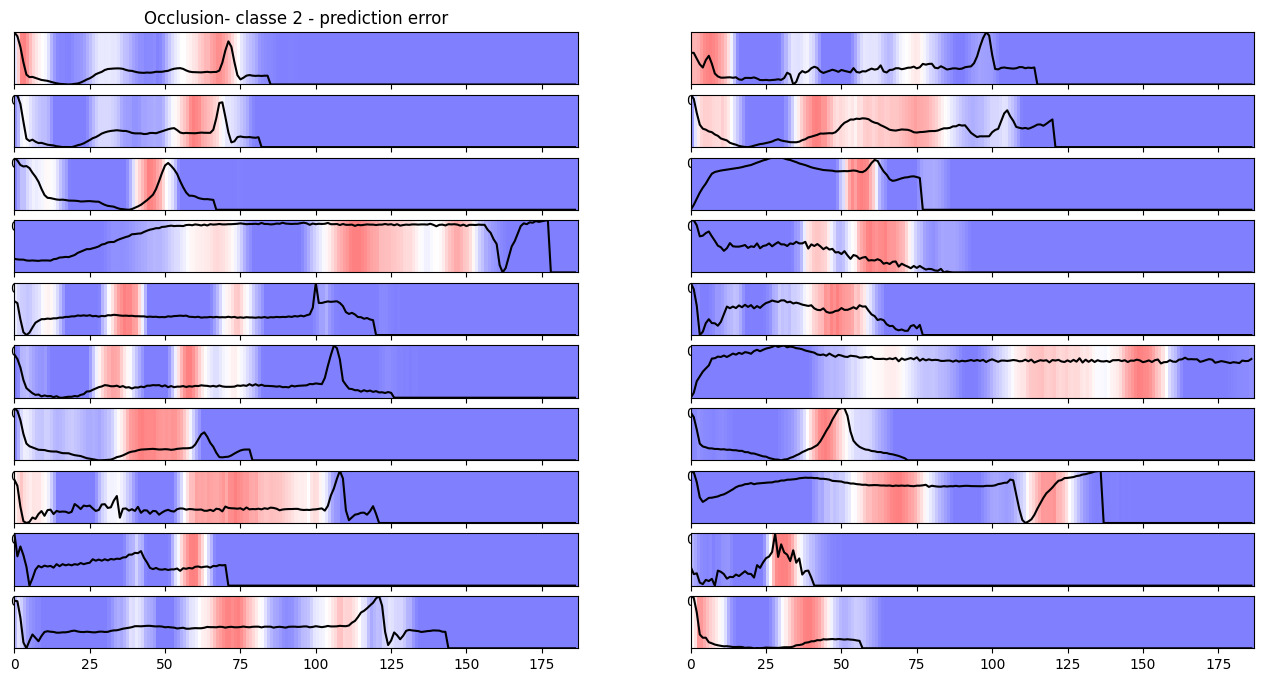

In [202]:
kk=2
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction error')

### Classe 4

20295
20295 true: 4 prediction 4
21587
21587 true: 4 prediction 4
21645
21645 true: 4 prediction 4
21260
21260 true: 4 prediction 4
21245
21245 true: 4 prediction 4
21758
21758 true: 4 prediction 4
20863
20863 true: 4 prediction 4
21086
21086 true: 4 prediction 4
20464
20464 true: 4 prediction 4
20753
20753 true: 4 prediction 4
20731
20731 true: 4 prediction 4
21507
21507 true: 4 prediction 4
21716
21716 true: 4 prediction 4
21890
21890 true: 4 prediction 4
20429
20429 true: 4 prediction 4
20734
20734 true: 4 prediction 4
21066
21066 true: 4 prediction 4
21814
21814 true: 4 prediction 4
20610
20610 true: 4 prediction 4
21170
21170 true: 4 prediction 4


Text(0.5, 1.0, 'Occlusion- classe 4 - prediction ok')

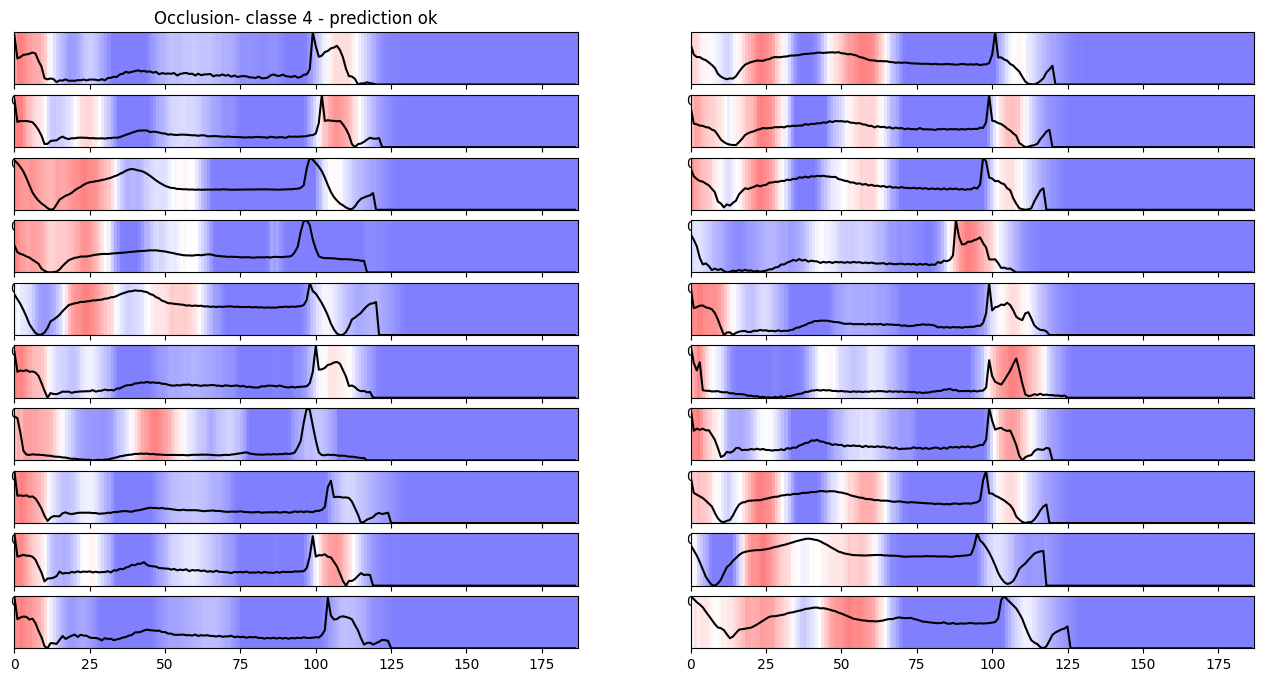

In [185]:
kk=4
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction ok')

21178
21178 true: 4 prediction 0
20383
20383 true: 4 prediction 0
20324
20324 true: 4 prediction 2
21099
21099 true: 4 prediction 0
21618
21618 true: 4 prediction 0
21832
21832 true: 4 prediction 0
20854
20854 true: 4 prediction 0
20906
20906 true: 4 prediction 0
20941
20941 true: 4 prediction 1


Text(0.5, 1.0, 'Occlusion- classe 4 - prediction error')

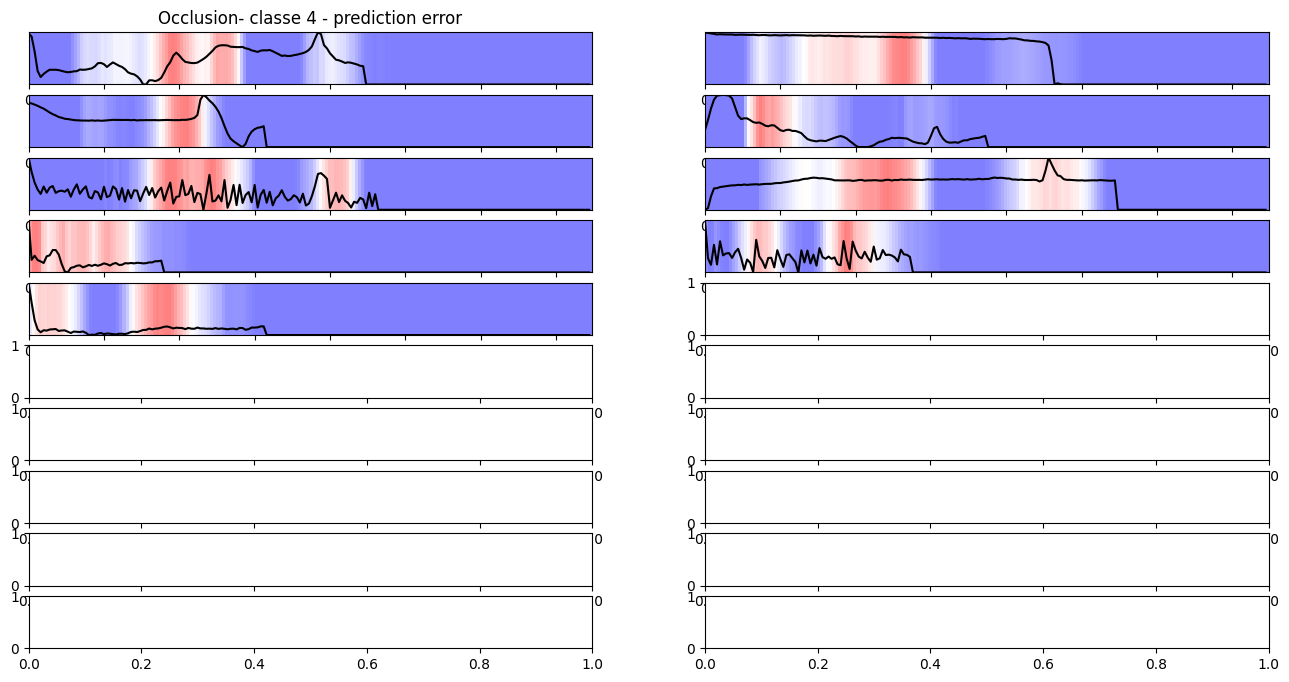

In [204]:
kk=4
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(9):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction error')

### Classe 0

14894
14894 true: 0 prediction 1
6240
6240 true: 0 prediction 2
7331
7331 true: 0 prediction 1
7109
7109 true: 0 prediction 1
3805
3805 true: 0 prediction 1
4989
4989 true: 0 prediction 1
7212
7212 true: 0 prediction 1
16383
16383 true: 0 prediction 1
15484
15484 true: 0 prediction 1
13448
13448 true: 0 prediction 1
1162
1162 true: 0 prediction 3
329
329 true: 0 prediction 3
15181
15181 true: 0 prediction 3
11949
11949 true: 0 prediction 1
3712
3712 true: 0 prediction 1
15078
15078 true: 0 prediction 1
10646
10646 true: 0 prediction 1
7176
7176 true: 0 prediction 2


C:\Users\passage\AppData\Local\Temp\ipykernel_8316\3305308350.py:19: RuntimeWarning: invalid value encountered in divide
  importance /= np.max(importance)  # Normaliser la heatmap


613
613 true: 0 prediction 4
3529
3529 true: 0 prediction 1


Text(0.5, 1.0, 'Occlusion- classe 0 - prediction ok')

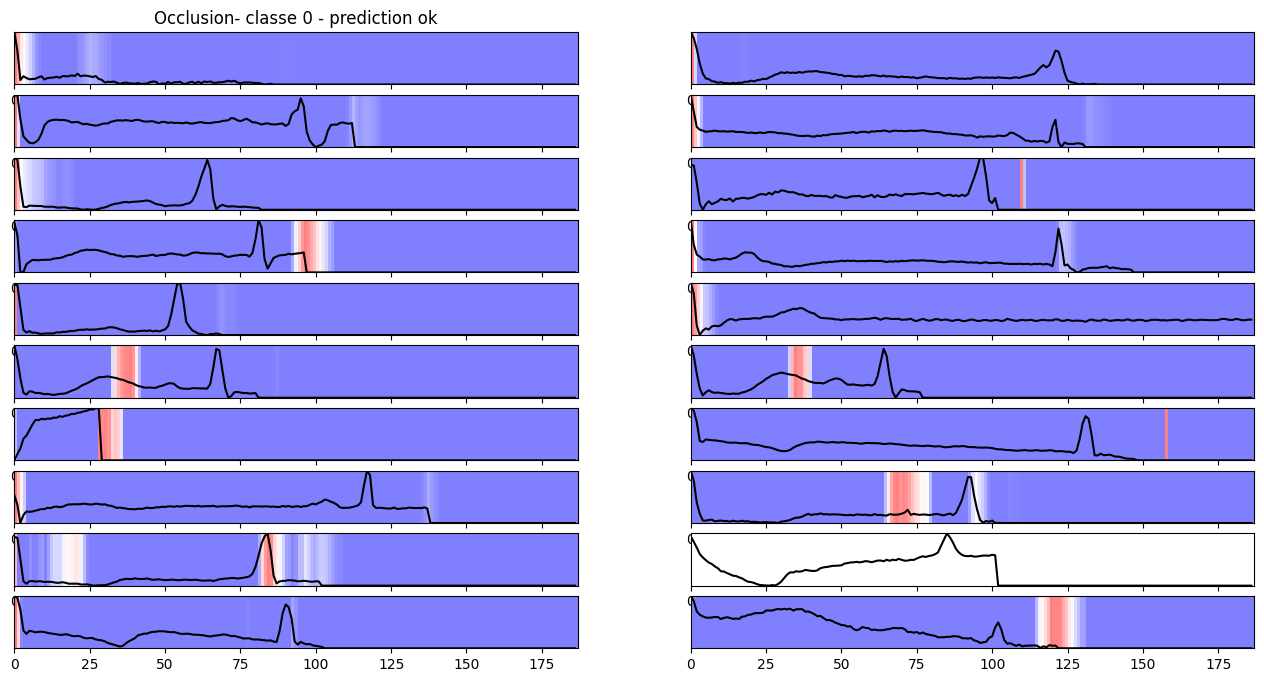

In [205]:
kk=0
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
   
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction ok')

994
994 true: 0 prediction 2


C:\Users\passage\AppData\Local\Temp\ipykernel_8316\3305308350.py:19: RuntimeWarning: invalid value encountered in divide
  importance /= np.max(importance)  # Normaliser la heatmap


613
613 true: 0 prediction 4
7254
7254 true: 0 prediction 1
841
841 true: 0 prediction 1
4989
4989 true: 0 prediction 1
3560
3560 true: 0 prediction 3
2788
2788 true: 0 prediction 2
5880
5880 true: 0 prediction 3
3156
3156 true: 0 prediction 4
15895
15895 true: 0 prediction 2
13773
13773 true: 0 prediction 2
11994
11994 true: 0 prediction 1
16822
16822 true: 0 prediction 1
11743
11743 true: 0 prediction 1
9590
9590 true: 0 prediction 1
15642
15642 true: 0 prediction 1
8125
8125 true: 0 prediction 1
15484
15484 true: 0 prediction 1
16164
16164 true: 0 prediction 1
14894
14894 true: 0 prediction 1


Text(0.5, 1.0, 'Occlusion- classe 0 - prediction error')

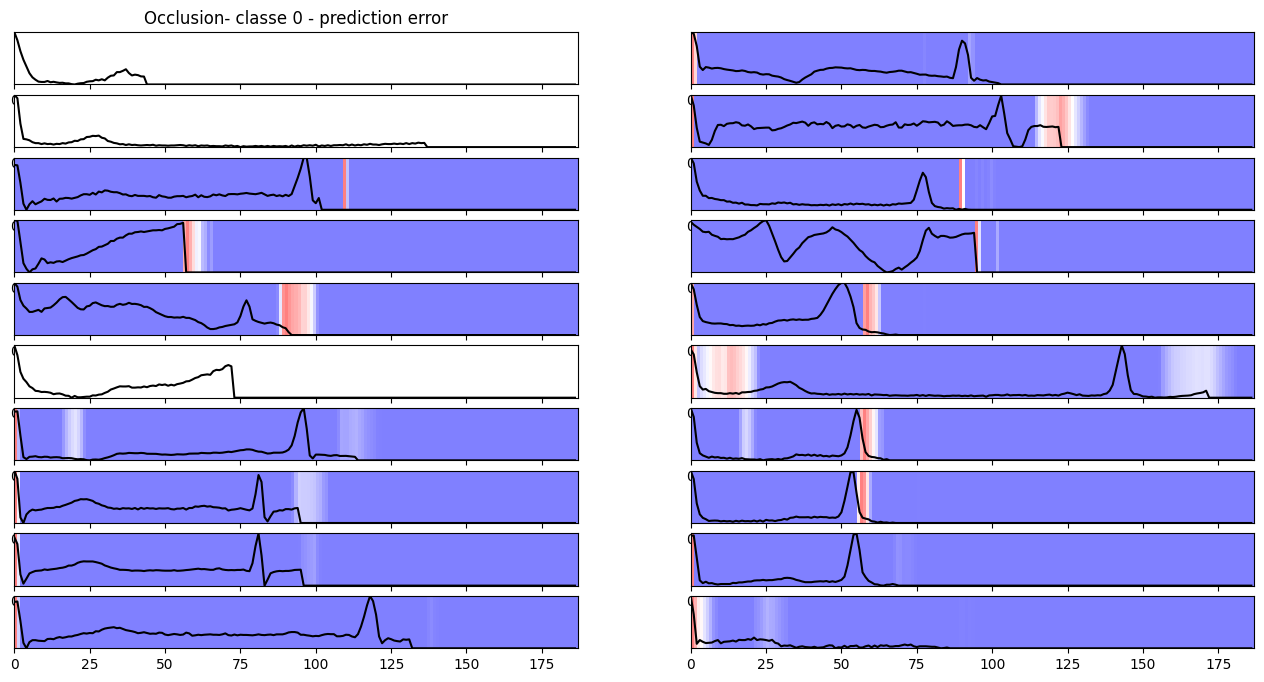

In [206]:
kk=0
fig,axs = plt.subplots(figsize=(16,8),nrows=10,ncols=2)
axs = axs.flatten()
b = class_error[kk]
np.random.shuffle(b)
for aff in range(20):
    
    ii = b[aff]
    print(ii)
    print(ii,'true:',kk,'prediction',y_pred[ii])
    heatmap = show_importance_occlusion(X[ii].unsqueeze(0), model, target=int(y[ii]))
   
    im = axs[aff].imshow(np.expand_dims(heatmap,axis=0),aspect='auto',cmap='bwr',alpha=0.5,extent=[0,187,0,1])
    axs[aff].plot(X[ii,0,:],color='k')
    axs[aff].set_yticks([])
axs[0].set_title('Occlusion- classe %d ' %kk +'- prediction error')